
# Healthcare Fraud Detection

## Explotary Data Analysis

In [1]:
#%pip install factor_analyzer

# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.example import visualize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt

## Feature Engineering
- Lead:
    - According the dataset and information from website, DRG's full name is diagnosis-realted group, and is a patient classification system that standardizes prospective payment to hospital. (sources:https://hmsa.com/portal/provider/zav_pel.fh.DIA.650.htm)
    - Hospital referral regions (HRRs) represent regional health care market for tertiary medical care that generally requires the services of a major referral center. (sources: http://archive.dartmouthatlas.org/data/region/  )
    - To identify the frauds, we should at least narrow down our dataset and ensure that we the comparisons are conducted under the same DRG definition with the relatively same oevrall situation, where we can use state or city to group all the providers.

- Analysis:
    - Use DRG definition and Hospital.Referral.Region.Description to divide the whole dataset
    - Get the mean and median values of each city's total discharges, average covered charges, average total payments, and average medicare payments by each DRG definition within the same Hospital Referral Region.
    - Append the average and median statistics back to the data to derive the ratios and also add insurance covered ratio and discharge's average covered charges to the new dataset

- Python code: Attached below

In [2]:
# load the data
payment = pd.read_csv("~/Desktop/L/Anomaly Detection/session 4/HW4/inpatientCharges.csv")

# order by DRG definition and hospital referral
payment_group = payment.groupby(['DRG Definition', 'Hospital Referral Region Description'])
payment_group.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44
...,...,...,...,...,...,...,...,...,...,...,...,...
163048,948 - SIGNS & SYMPTOMS W/O MCC,520113,BAY AREA MED CTR,3100 SHORE DR,MARINETTE,WI,54143,WI - Green Bay,22,$11789.36,$4114.00,$3346.54
163052,948 - SIGNS & SYMPTOMS W/O MCC,520160,APPLETON MED CTR,1818 N MEADE ST,APPLETON,WI,54911,WI - Appleton,19,$7100.84,$3830.10,$3123.57
163056,948 - SIGNS & SYMPTOMS W/O MCC,530002,CAMPBELL COUNTY MEMORIAL HOSPITAL,501 SOUTH BURMA AVENUE,GILLETTE,WY,82716,MT - Billings,12,$13756.50,$6889.33,$5673.50
163057,948 - SIGNS & SYMPTOMS W/O MCC,530012,WYOMING MEDICAL CENTER,1233 EAST 2ND ST,CASPER,WY,82601,WY - Casper,19,$12021.42,$6192.84,$3580.57


In [3]:
payment.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

In [4]:
# clean up the column names
cleaned_columns = []

for column in payment.columns:
    c = column.strip()
    cleaned_columns.append(c)
      
print(cleaned_columns)

# replace the original column names
payment.columns = cleaned_columns

['DRG Definition', 'Provider Id', 'Provider Name', 'Provider Street Address', 'Provider City', 'Provider State', 'Provider Zip Code', 'Hospital Referral Region Description', 'Total Discharges', 'Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments']


In [5]:
# examine the types of data
payment.dtypes
# change object to numeric
payment[['Average Covered Charges','Average Total Payments','Average Medicare Payments']] = payment[['Average Covered Charges','Average Total Payments','Average Medicare Payments']].replace('[\$,]', '', regex=True).astype(float)

In [6]:
payment.dtypes

DRG Definition                           object
Provider Id                               int64
Provider Name                            object
Provider Street Address                  object
Provider City                            object
Provider State                           object
Provider Zip Code                         int64
Hospital Referral Region Description     object
Total Discharges                          int64
Average Covered Charges                 float64
Average Total Payments                  float64
Average Medicare Payments               float64
dtype: object

In [7]:
# Create benchmark by DRG Definition & Hospital Referral Region Description
DRG_referral = payment.groupby(
                    ['DRG Definition', 'Hospital Referral Region Description'], as_index = False).aggregate(
                    {
                        'Provider Name':'count',
                        'Total Discharges': 'mean',
                        'Average Covered Charges': 'mean',
                        'Average Total Payments': 'mean',
                        'Average Medicare Payments':'mean'
                    })
DRG_referral.columns = ['DRG Definition','Hospital Referral Region Description','Count','Mean Total Discharges','Mean Average Covered Charges','Mean Average Total Payments',
                       'Mean Average Medicare Payments']
DRG_referral.head()

,DRG Definition,Hospital Referral Region Description,Count,Mean Total Discharges,Mean Average Covered Charges,Mean Average Total Payments,Mean Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AK - Anchorage,1,23.000000,34805.130000,8401.950000,6413.780000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,13,27.461538,40237.356923,5738.564615,4604.024615
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Dothan,2,68.000000,36285.175000,5566.760000,4585.965000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Huntsville,2,81.000000,18878.950000,5894.965000,4868.755000
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Mobile,5,30.000000,22802.266000,5500.038000,4261.122000


In [8]:
# Get the ratios based on the benchmark created above
original = pd.merge(payment,DRG_referral)
original
# create 9 ratios and attached to the original dataset

original['ratio total discharges'] = original['Total Discharges']/original['Mean Total Discharges']
original['ratio average covered charges'] = original['Average Covered Charges']/original['Mean Average Covered Charges']
original['ratio average total payments'] = original['Average Total Payments']/original['Mean Average Total Payments']
original['ratio average medicare payments'] = original['Average Medicare Payments']/original['Mean Average Medicare Payments']
original['ratio diff insurance covered'] = original['Average Medicare Payments']/original['Average Total Payments']- original['Mean Average Medicare Payments']/original['Mean Average Total Payments']
original['ratio mean covered discharge'] = (original['Average Covered Charges']/original['Total Discharges'])/((original['Average Covered Charges']/original['Total Discharges']).mean())
original['ratio mean totalpay discharge'] = (original['Average Total Payments']/original['Total Discharges'])/((original['Average Total Payments']/original['Total Discharges']).mean())
original['ratio mean medicare discharges'] = (original['Average Medicare Payments']/original['Total Discharges'])/((original['Average Medicare Payments']/original['Total Discharges']).mean())
original['ratio diff mean total payments'] = original['Average Covered Charges']/original['Average Total Payments'] - ((original['Average Covered Charges']/original['Average Total Payments']).mean())/original['Mean Average Total Payments']
original.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Mean Average Medicare Payments,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4585.965000,1.338235,0.908445,1.037810,1.038763,0.000756,0.239280,0.155999,0.146524,5.705000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10055,FLOWERS HOSPITAL,4370 WEST MAIN STREET,DOTHAN,AL,36305,AL - Dothan,45,39607.28,...,4585.965000,0.661765,1.091555,0.962190,0.961237,-0.000816,0.581410,0.292478,0.274190,7.393872
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4604.024615,0.509804,0.376065,1.008540,1.080948,0.057601,0.713976,1.015804,0.994987,2.613885
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4604.024615,0.873950,0.933470,0.947092,0.967369,0.017177,1.033804,0.556450,0.519424,6.910238
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,4604.024615,0.910364,0.347893,0.944062,0.896859,-0.040115,0.369875,0.532483,0.462301,2.583214


- Conclusion
    - Rather than use DRG defination and State to group the providers, I use hospitla referral regions to divide the whole dataset. That is, to ensure the fraud detection is under the same DRG definition and the same hospital referral regions. The main reason to use hospital referral regions is even though I narrow down the dataset to each state, different cities have different infrastructure levels and economic conditions. Even in the same city, areas in suburban and urban might have differenet conditions.     
    - All the features are using ratio in order to minimize the effect of cardinal. For example, the last three features in my feature engineering process, that is, the ratio of each provider's total payment per discharge to the median level under the benchmark of DRG definition and hospital referral regions, the ratio of each provider's medicare payment per discharge to the median level under the benchmark of DRG definition and hospital referral regions, and the difference between the ratio of each provider's average covered charges to average total payments and the median ratio under the benchmark of DRG definition and hospital referral regions.

## Standardization

- Lead
    - It is important to standardize variables to ensure they receive the same weight in analysis
    - Approaches such as Z-score can help us to standardize
- Analysis
    - In this part, I will just use the function scale to standardize the data
- Python code: Attached bellow

In [9]:
# select variables
data = original[original.columns[17:26]]
data.head()

#standar
newdf = pd.DataFrame(preprocessing.scale(data), index = data.index, columns = data.columns)
newdf.head()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
0,0.567237,-0.288065,0.237583,0.220345,0.012636,-0.557211,-0.731800,-0.692929,1.024451
1,-0.567237,0.288065,-0.237583,-0.220345,-0.015090,-0.306608,-0.613465,-0.589278,1.920310
2,-0.822082,-1.963118,0.053660,0.460142,1.015266,-0.209506,0.013703,-0.004070,-0.615223
3,-0.211393,-0.209326,-0.332451,-0.185489,0.302260,0.024761,-0.384585,-0.390176,1.663767
4,-0.150324,-2.051757,-0.351492,-0.586299,-0.708251,-0.461553,-0.405366,-0.436553,-0.631493


- Conclusion
    - As shown above, I have standardized the data and it can be used for further analysis.

## Variable Selection (Before clustering)

- Lead
    - Before clustering, we need to examine the if it is necessary to conduct factor analysis. 
    - Variables with high correlations will have a great impact on the clustering result and 
    - Correlation matrix can examine the correlation between each variable
    - Bartlett’s Test of Sphericity is to see if there are at least some non-zero correlations by comparing correlation matrix to an identity matrix. A significant test indicates suitability for factor analysis.
    - KMO Measure of Sampling Adequacy compares partial correlation matrix to pairwise correlation matrix. A partial correlation is a correlation after partialing out all other correlations. If the variables are strongly related, partial correlations should be small and MSA close to 1. If MSA > 0.5, data is suitable for factor analysis.
    
- Analysis
    - Use corr and heatmap to get the plot of correlations between each variables
    - Find out if there are variables have correlations larger than 0.5
    - Use calculate_bartlett_sphericity function and check the significance
    - Use calculate_kmo function and check out MSA for each variable
  
- Python code: Attached below

[Text(0.5, 0, 'ratio total discharges'),
 Text(1.5, 0, 'ratio average covered charges'),
 Text(2.5, 0, 'ratio average total payments'),
 Text(3.5, 0, 'ratio average medicare payments'),
 Text(4.5, 0, 'ratio diff insurance covered'),
 Text(5.5, 0, 'ratio mean covered discharge'),
 Text(6.5, 0, 'ratio mean totalpay discharge'),
 Text(7.5, 0, 'ratio mean medicare discharges'),
 Text(8.5, 0, 'ratio diff mean total payments')]

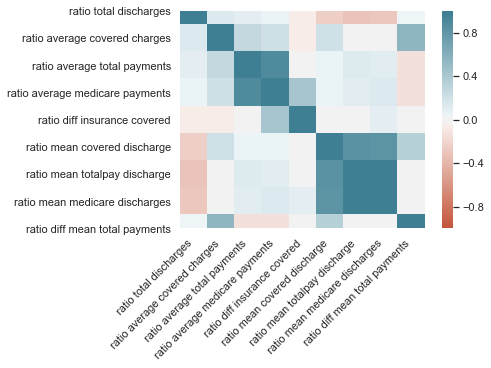

In [10]:
# correlation matrix heatmap

corr = newdf.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [11]:
# Bartlett’s Test of Sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(newdf)
chi_square_value, p_value

(1770460.3284136693, 0.0)

In [12]:
# KMO
kmo_all,kmo_model=calculate_kmo(newdf)
kmo_all,kmo_model

(array([0.75194965, 0.65110649, 0.31179301, 0.34660916, 0.10300956,
        0.82025621, 0.59476832, 0.6046943 , 0.44698587]), 0.47489745483422663)

- Conclusion
    - As we can see, some variables have high correlations with each other. For example, the correlation between ratio average total payments and ratio average medicare payments is larger than 0.5. So, before use pyod, we need to solve the provblem of high correlations. As for the Bartlett’s Test of Sphericity, the p value is less than 0.05, which means it is significant. Meanwhile, the  result of KMO Measure of Sampling Adequacy shows the values of some variables are larger than 0.5 though the overall level is less than 0.5.
    - As a result, we need to solve the problem of high correlations before use KNN to identify outliers.

## Approaches to solve high correlations 

- Lead
    - To solve the problems listed above, there are several approaches, including variable elimination, factor analysis, variable index, and use a different distance measure.
    - The simplest approach for dealing with this situation, if the correlations are very high (e.g., .80 or higher), is to eliminate one of the two variables from the analysis. The variable to be retained in the analysis should be selected based on its practical usefulness or actionability potential.
    - Use mahalanobis distance to cluster will eliminate the effect of  high correlations
- Analysis
    - First, I try to calculate mahalanobis distance and then use the hclust fucntion to cluster
    - However, this method doesn't work in this assignment. Because calculation of the Mahalanobis distance measure, especially when there are more than a few variables can be a complicated, time consuming, iterative procedure.
    - The simpliest approach, just eliminate variables with high correlations.
    -  Use PCA to divide the dataset into several components.

sources: Cluster Analysis Gets Complicated: https://www.trchome.com/docs/5-cluster-analysis-gets-complicated/file

- Python code: Attached below

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
df_pca = pca.fit_transform(newdf)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8
0,-1.067708,0.506271,0.651283,-0.224288,0.142118,-0.943066,-0.323653,-0.004850,0.020833
1,-0.600304,-0.290431,1.474877,-0.832838,-0.855740,-0.858206,-0.481922,-0.008694,0.020528
2,-0.010348,0.000145,-2.107612,-0.897318,-0.217439,-0.948896,-0.007358,0.046234,-0.020732
3,-0.320698,-0.377438,1.014113,-0.940172,-0.245430,-1.042877,-0.295851,0.025064,-0.005521
4,-1.131109,-1.080325,-1.506300,0.612357,-0.037593,-1.035053,0.061323,-0.031372,0.002441


In [14]:
# Get the variance explained by each of the principal components
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.32944529, 0.22691866, 0.18430371, 0.11550946, 0.08922948,
       0.04011539, 0.01273651, 0.00114121, 0.00060028])

In [15]:
# choose the first five components
df_pca.columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']
df_pca.head()
newdata = df_pca[['PC1','PC2','PC3','PC4','PC5']]
newdata.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.067708,0.506271,0.651283,-0.224288,0.142118
1,-0.600304,-0.290431,1.474877,-0.832838,-0.855740
2,-0.010348,0.000145,-2.107612,-0.897318,-0.217439
3,-0.320698,-0.377438,1.014113,-0.940172,-0.245430
4,-1.131109,-1.080325,-1.506300,0.612357,-0.037593


In [16]:
# eliminate variables with high correlations
data2 = newdf[['ratio total discharges','ratio average covered charges','ratio average total payments','ratio diff insurance covered','ratio mean totalpay discharge','ratio diff mean total payments']]

- Conclusion
    - As we can see, the first five components account for 94.45% the variability in the dataset. So, if we choose pca to analyze, we can use the first five componenets.
    - Meanwhile, we can directly eliminate some variables with high correlations. Based on the previous analysis, the overall KMO value is less than 0.5, which means component analysis is not necessary at this time. Thus, I will just eliminate some variables from the dataset in the following analysis

## KNN: An Unsuperivised technique

- Lead: 
    - An outlier is any data point which differs greatly from the rest of the observations in a dataset.
    - PyOD is a scalable Python toolkit for detecting outliers in multivariate data. It provides access to around 20 outlier detection algorithms under a single well-documented API.
    - kNN class for outlier detection: For an observation, its distance to its kth nearest neighbor could be viewed as the outlying score. It could be viewed as a way to measure the density
- Analysis:
    - Data preparation: Split the data into train and test
    - Train KNN detector
    - Generate raw outlier score, get the prediction on the test data, and then use clf.decision_function to predict raw anomaly score of X using the fitted detector.
    - Get the unique test prediction with counts
    - Identify the outliers as a cluster and demonstrate the X attributes.
- Python code: Attached below   

In [17]:
# split data into train and test
train, test = train_test_split(data2, test_size = 0.2)

In [18]:
# train KNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [19]:
# raw outlier score
train_scores = clf.decision_scores_

# get the prediction on the test data
test_pred = clf.predict(test) # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
test_scores = clf.decision_function(test)  # outlier scores

In [20]:
unique, counts = np.unique(test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 29348, 1: 3265}

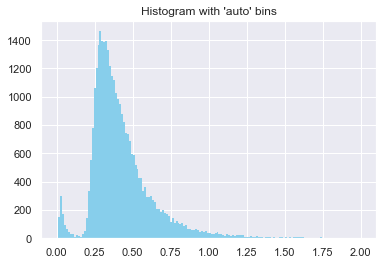

In [21]:
plt.hist(test_scores, bins='auto',range=[0, 2], color='skyblue',lw=0)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [22]:
# identify the outlier as a cluster
df_test = pd.DataFrame(test)
df_test['score'] = test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()

0    31762
1      851
Name: cluster, dtype: int64

In [23]:
outlier_percentage = 851/(31762+851)
outlier_percentage

0.026093888939993256

In [24]:
# describe the outlier
df_test.groupby('cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,score
cluster,,,,,,,
0,-0.013144,-0.046270,-0.042757,0.016358,-0.049815,-0.024347,0.407431
1,0.364237,1.547239,1.580480,-0.454126,1.856987,0.836319,1.361743


In [25]:
outlier = df_test[df_test['cluster']==1]
outlier.head()
idx = outlier.index

outlier_original = original.loc[idx]
outlier_original.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Mean Average Medicare Payments,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
109783,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,440049,METHODIST HEALTHCARE MEMPHIS HOSPITALS,1265 UNION AVE SUITE 700,MEMPHIS,TN,38104,TN - Memphis,71,110359.30,...,21472.068000,1.425703,1.263437,1.457599,1.052931,-0.225561,1.026763,1.333194,0.891289,2.864687
129890,"640 - MISC DISORDERS OF NUTRITION,METABOLISM,F...",110115,ATLANTA MEDICAL CENTER,303 PARKWAY DR NE,ATLANTA,GA,30312,GA - Atlanta,25,55827.08,...,6305.771613,0.598918,2.216183,1.349308,1.448070,0.063653,1.475111,0.961645,1.022330,5.705483
40280,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,330214,NYU HOSPITALS CENTER,550 FIRST AVENUE,NEW YORK,NY,10016,NY - Manhattan,21,251098.90,...,58549.422727,0.629428,2.035961,1.091849,1.112890,0.018623,7.898512,7.740413,8.684784,3.795736
145028,698 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W...,150056,INDIANA UNIVERSITY HEALTH,1701 N SENATE BLVD,INDIANAPOLIS,IN,46206,IN - Indianapolis,75,52814.60,...,9440.990000,3.214286,1.678975,1.870602,1.428886,-0.205719,0.465171,0.664152,0.503451,2.605009
126710,603 - CELLULITIS W/O MCC,320065,LEA REGIONAL MEDICAL CENTER,5419 N LOVINGTON HIGHWAY,HOBBS,NM,88240,TX - Lubbock,13,23551.76,...,4447.815000,0.435754,1.308357,1.634111,1.116883,-0.240132,1.196740,1.810829,1.069583,2.457709


- Conclusion
    - Using KNN, the smallest cluster identified is cluster 1 and the size is 868, which means the percentage of suspicious providers is 2.686045442001656%. Then, by comparing the average statistics to examine outliers, the centers of cluster 1 is much larger than the others. Thus, we can conclude that cluster 1 is outlier.
    - To examine the average statistics by each variable, we can see ratio average covered charges, ratio average total payments, ratio mean totalpay discharge, and ratio diff mean total payments are much larger. That is to say, providers which have waste or abuse phenomenon might focus on two aspects, including covered charges and total payments.
    - Using index to return the result of original dataset, we can get the specific information of outleirs, including provider name, state, etc. 

## Achieve Model Stability by Aggregating Multiple Models

- Lead: 
    - Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
    - The solution is to train multiple models then aggregate the scores
    - For the methods to aggregate the outcome, we can use average scores of all detectors, maximum of maximum(MOM), average of maximum(AOM), and maximum of average(MOA).
- Analysis:
    - split the data into train and test
    - Use circulation to get the result of a range of n_neighbors from 10 to 200
    - Get the average scores of all detectors
    - identify the outlier
- Python code: Attached below

In [26]:
n_clf = 10

In [27]:
# split data into train and test
train1, test1 = train_test_split(data2, test_size = 0.2)

In [28]:
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [29]:
train_scores = np.zeros([train1.shape[0], n_clf])
test_scores = np.zeros([test1.shape[0], n_clf])

In [30]:
train_scores.shape

(130452, 10)

In [31]:
for i in range(n_clf):
        k = k_list[i]

        clf = KNN(n_neighbors=k, method='largest')
        clf.fit(train1)

        train_scores[:, i] = clf.decision_scores_
        test_scores[:, i] = clf.decision_function(test1) # Predict raw anomaly score of X using the fitted detector.

In [32]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

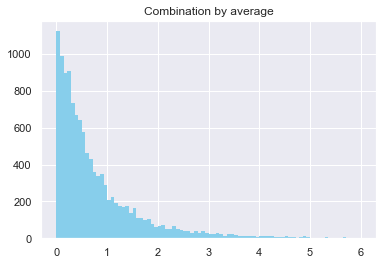

In [33]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto',range=[0, 6], color='skyblue',lw=0)  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [34]:
# identify the outlier as a cluster
df_test = pd.DataFrame(test1)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<3, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    32104
1      509
Name: y_by_average_cluster, dtype: int64

In [35]:
# calculate the outlier percentage
avg_outlier = 509/(509+32104)
avg_outlier

0.01560727317327446

In [36]:
# describe the outlier
df_test.groupby('y_by_average_cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.009615,-0.030759,-0.034588,0.010053,-0.022895,-0.008795,-0.065705
1,0.481399,1.876418,2.034876,-0.669540,2.382137,0.711334,5.056267


In [37]:
avg_outlier = df_test[df_test['y_by_average_cluster'] == 1]
avg_outlier.head()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score,y_by_average_cluster
531,-1.110883,2.581353,5.117624,0.955576,2.402061,-1.437667,4.543170,1
84633,-0.911684,-0.005207,-1.685687,5.054859,1.038312,0.329374,3.334412,1
92068,-0.520463,3.729628,7.392357,0.911650,2.643487,-1.437567,7.395145,1
92820,0.683242,-0.313910,-1.755081,4.441667,-0.601048,1.535443,3.173834,1
38990,-0.552199,-1.289110,15.246072,-3.700497,7.167444,-1.900064,27.554385,1


- Conclusion
    - Because of KNN is sensitive to the value of k, I use average method to achieve its stability.
    - Based on the average statistics and cluster size, the outlier is cluster 1 with the size of 482. 
    - Using index to find out the problematic hospitals in the original dataset, we can get all the providers' information, among which might exist waste and abuse. 
    - Finally, compared to the previous result, when we use the stable model, the size of outlier seems smaller.

## Isolated Forest

- Lead:
    - Isolated Forest is an anomaly detection algorithm created by Fei Tony Liu et al. It is an alternative approach, that is, exlicitly isolating anomalies instead of profiling normal data points. 
    - Anomalies are isolated closer to the root of the tree while normal points are isolated at the deeper end of the tree.
    - It is a two-stage process: The first(training) stage builds isolation trees using subsamples of the training set. The second stage(testing) passes the test instances through isolation trees to obtain an anomaly score for each isntance.
- Analysis:
    - Build the IForest model and fit the model
    - Apply the model to the test data test2 to get the outlier scores
    - Get the cutoff using the plot and get the summary statistics by cluster
    - Based on the cluster size and average statistics, we can get the outliers
- Python code: Attached below    

In [38]:
from pyod.models.iforest import IForest

In [39]:
# split data into train and test
train2, test2 = train_test_split(data2, test_size = 0.2)

### Model1 max_samples = 100

In [40]:
# build the model1
clf1 = IForest(behaviour = 'new', max_samples = 100)
clf1.fit(train2)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

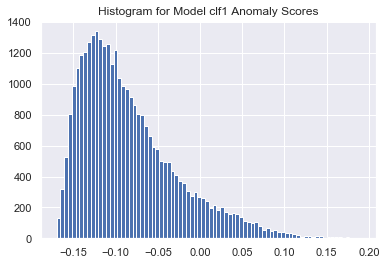

In [41]:
# apply the model to the test data test2 to get the outlier scores
test2_scores = clf1.decision_function(test2) #outlier scores
test2_scores = pd.Series(test2_scores)
test2_scores.head()

plt.hist(test2_scores, bins = 'auto') # arguemnts are passed to np.histogram
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()

In [42]:
test2_scores = list(test2_scores)

In [43]:
# Get the summary statistics by cluster
test2_cluster = test2.copy()
test2_cluster['distance'] = test2_scores
test2_cluster['cluster'] = np.where(test2_cluster['distance']<0.08,0,1)
test2_cluster['cluster'].value_counts()

test2_cluster.groupby('cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,distance
cluster,,,,,,,
0,-0.013646,-0.039545,-0.040786,0.003642,-0.031587,-0.01884,-0.086820
1,0.649312,2.308391,2.097935,-0.703394,2.005063,1.18348,0.109911


In [44]:
test2_cluster['cluster'].value_counts()

0    32146
1      467
Name: cluster, dtype: int64

- Conclusion:
    - As the result shown above, cluster 1 can be identified as outlier since the size of cluster 1 is much smaller than cluster 0 and according to the average statistics, the centers of clsuter1 is larger than cluster than 0.

### Model2 max_samples= 80

In [45]:
# build the model2
clf2 = IForest(behaviour = 'new', max_samples = 80)
clf2.fit(train2)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=80, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

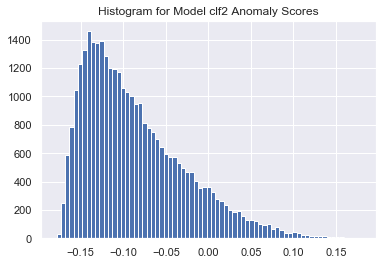

In [46]:
# apply the model to the test data test2 to get the outlier scores
test2_scores2 = clf2.decision_function(test2) #outlier scores
test2_scores2 = pd.Series(test2_scores2)
test2_scores2.head()

plt.hist(test2_scores2, bins = 'auto') # arguemnts are passed to np.histogram
plt.title("Histogram for Model clf2 Anomaly Scores")
plt.show()

In [47]:
# Get the summary statistics by cluster
test2_cluster2 = test2.copy()
test2_cluster2['distance'] = test2_scores
test2_cluster2['cluster'] = np.where(test2_cluster2['distance']<0.1,0,1)
test2_cluster2['cluster'].value_counts()

test2_cluster2.groupby('cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,distance
cluster,,,,,,,
0,-0.010688,-0.027269,-0.032760,-0.000024,-0.019102,-0.010642,-0.085679
1,0.818643,2.681481,2.835086,-0.819615,2.097344,1.133838,0.127036


In [48]:
test2_cluster2['cluster'].value_counts()

0    32356
1      257
Name: cluster, dtype: int64

- Conclusion:
    - As the result shown above, cluster 1 can be identified as outlier since the size of cluster 1 is much smaller than cluster 0 and according to the average statistics, the centers of clsuter1 is larger than cluster than 0.

### Model3 max_samples = 60

In [49]:
# build the model3
clf3 = IForest(behaviour = 'new', max_samples = 60)
clf3.fit(train2)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=60, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

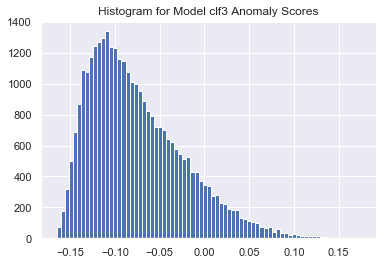

In [50]:
# apply the model to the test data test2 to get the outlier scores
test2_scores3 = clf3.decision_function(test2) #outlier scores
test2_scores3 = pd.Series(test2_scores3)
test2_scores3.head()

plt.hist(test2_scores3, bins = 'auto') # arguemnts are passed to np.histogram
plt.title("Histogram for Model clf3 Anomaly Scores")
plt.show()

In [51]:
test2_scores = list(test2_scores)

In [52]:
# Get the summary statistics by cluster
test2_cluster3 = test2.copy()
test2_cluster3['distance'] = test2_scores
test2_cluster3['cluster'] = np.where(test2_cluster3['distance']<0.12,0,1)
test2_cluster3['cluster'].value_counts()

test2_cluster3.groupby('cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,distance
cluster,,,,,,,
0,-0.008388,-0.018912,-0.024518,-0.002891,-0.011110,-0.005532,-0.084907
1,1.070630,3.290329,3.633581,-0.918052,2.202165,0.990475,0.145468


In [53]:
test2_cluster3['cluster'].value_counts()

0    32485
1      128
Name: cluster, dtype: int64

- Conclusion:
    - As the result shown above, cluster 1 can be identified as outlier since the size of cluster 1 is much smaller than cluster 0 and according to the average statistics, the centers of clsuter1 is larger than cluster than 0.

## Achieve Model Stability by Aggregating Multiple Models (IForest Average)

- Lead: 
    - Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
    - The solution is to train multiple models then aggregate the scores
    - For the methods to aggregate the outcome, we can use average scores of all detectors, maximum of maximum(MOM), average of maximum(AOM), and maximum of average(MOA).
- Analysis:
    - split the data into train and test
    - Use circulation to get the result of a range of n_neighbors from 10 to 200
    - Get the average scores of all detectors
    - identify the outlier
- Python code: Attached below

In [54]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(test2),
                             'clf2': clf2.decision_function(test2),
                             'clf3': clf3.decision_function(test2) 
                            })

In [55]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)
train_scores_norm.shape

(130452, 3)

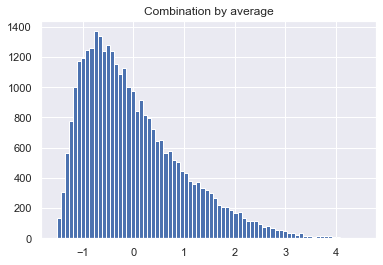

In [56]:
# Combination by average
y_by_average = average(test_scores_norm)
             
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [57]:
df_test2 = test2.copy()
df_test2['y_by_average_score'] = y_by_average
df_test2['y_by_average_cluster'] = np.where(df_test2['y_by_average_score']<3, 0, 1)
df_test2['y_by_average_cluster'].value_counts()

df_test2.groupby('y_by_average_cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.010055,-0.029752,-0.032628,0.001282,-0.017505,-0.013415,-0.037085
1,0.705463,2.859209,2.691196,-0.940120,1.810914,1.416264,3.444888


In [58]:
df_test2['y_by_average_cluster'].value_counts()

0    32344
1      269
Name: y_by_average_cluster, dtype: int64

In [59]:
avg_outlier2 = df_test2[df_test2['y_by_average_cluster'] == 1]
avg_outlier2.head()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score,y_by_average_cluster
60752,-1.387004,-1.526415,5.427356,0.309182,3.889681,-1.202474,3.469514,1
151139,-1.151406,0.471272,3.376322,-0.768313,8.464094,-0.719249,3.182523,1
42366,5.748125,6.482523,3.039420,-0.538192,-0.488039,1.379149,4.039934,1
145294,-0.407931,3.771903,3.154523,-0.590232,1.839175,1.213491,3.444450,1
58818,0.402492,2.998651,2.062154,0.710318,0.708622,3.544836,3.319502,1


- Conclusion:
    - As the result shown above, cluster 1 can be identified as outlier since the size of cluster 1 is much smaller than cluster 0 and according to the average statistics, the centers of clsuter1 is larger than cluster than 0.

## Comparison between KNN and IForest
- Lead:
    - KNN, basically it means to find  k nearest negihbors and the main idea of IForest is to use the neutral network. By comparing the result of two approaches, we can make our result more reasonable.
    - By comparing the specific providers between two outlier clusters, we can find out the overlapped providers.
- Analysis:
    - Compare the size of two cluster and the variables have high average statistics.
    - Find out the overlapped providers between two outliers.
- Python code: Attached below

In [60]:
df_test.groupby('y_by_average_cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.009615,-0.030759,-0.034588,0.010053,-0.022895,-0.008795,-0.065705
1,0.481399,1.876418,2.034876,-0.669540,2.382137,0.711334,5.056267


In [61]:
df_test2.groupby('y_by_average_cluster').mean()

,ratio total discharges,ratio average covered charges,ratio average total payments,ratio diff insurance covered,ratio mean totalpay discharge,ratio diff mean total payments,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.010055,-0.029752,-0.032628,0.001282,-0.017505,-0.013415,-0.037085
1,0.705463,2.859209,2.691196,-0.940120,1.810914,1.416264,3.444888


In [63]:
df_test['y_by_average_cluster'].value_counts()

0    32104
1      509
Name: y_by_average_cluster, dtype: int64

In [64]:
df_test2['y_by_average_cluster'].value_counts()

0    32344
1      269
Name: y_by_average_cluster, dtype: int64

In [65]:
# use the index of outliers to the original dataset
idx1 = avg_outlier.index

outlier_original1 = original.loc[idx1]
outlier_original1.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Mean Average Medicare Payments,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
531,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,210029,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,4940 EASTERN AVENUE,BALTIMORE,MD,21224,MD - Baltimore,11,17955.63,...,8233.980833,0.337596,1.820428,1.814443,1.925579,0.054217,1.078271,3.770350,4.034426,1.063414
84633,314 - OTHER CIRCULATORY SYSTEM DIAGNOSES W MCC,50121,ADVENTIST MEDICAL CENTER,115 MALL DRIVE,HANFORD,CA,93230,CA - Fresno,17,66815.76,...,14093.827500,0.456376,0.998345,0.731732,1.040922,0.286627,2.596270,2.197508,2.415470,4.394641
92068,377 - G.I. HEMORRHAGE W MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,22,38563.63,...,15553.618000,0.689655,2.185383,2.176454,2.297010,0.051726,1.157911,4.048792,4.545429,1.063602
92820,377 - G.I. HEMORRHAGE W MCC,450102,MOTHER FRANCES HOSPITAL,800 EAST DAWSON,TYLER,TX,75701,TX - Tyler,76,63279.09,...,8489.725000,1.407407,0.900230,0.720688,1.002199,0.251862,0.550005,0.306798,0.313355,6.668322
38990,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,7965.18,...,3062.028000,0.670732,0.590284,3.426332,0.584639,-0.209761,0.478325,9.266372,0.455520,0.191703


In [66]:
# use the index of outliers to the original dataset
idx2 = avg_outlier2.index

outlier_original2 = original.loc[idx2]
outlier_original2.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Mean Average Medicare Payments,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
60752,291 - HEART FAILURE & SHOCK W MCC,50528,MEMORIAL HOSPITAL LOS BANOS,520 WEST I ST,LOS BANOS,CA,93635,CA - Modesto,13,43740.84,...,14849.251667,0.172949,0.514861,1.863735,1.898075,0.017569,2.222612,5.486055,6.068453,1.506800
151139,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,450213,UNIVERSITY HEALTH SYSTEM,4502 MEDICAL DR,SAN ANTONIO,TX,78229,TX - San Antonio,14,148253.64,...,37325.320000,0.313433,1.149784,1.537324,1.465832,-0.043520,6.995151,10.761827,10.938630,2.417776
42366,208 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,390164,UPMC PRESBYTERIAN SHADYSIDE,200 LOTHROP STREET,PITTSBURGH,PA,15213,PA - Pittsburgh,112,126998.75,...,12489.797037,4.427526,3.060332,1.483708,1.435095,-0.030473,0.749033,0.437133,0.447941,6.373677
145294,698 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W...,330141,BROOKHAVEN MEMORIAL HOSPITAL MEDICAL CENTER,101 HOSPITAL ROAD,PATCHOGUE,NY,11772,NY - East Long Island,16,123192.93,...,12108.540714,0.756757,2.198819,1.502026,1.445927,-0.033424,5.086108,3.121161,3.062819,6.061378
58818,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...",390290,HAHNEMANN UNIVERSITY HOSPITAL,230 NORTH BROAD STREET,PHILADELPHIA,PA,19102,PA - Philadelphia,31,239735.19,...,15903.038947,1.240000,1.953058,1.328181,1.386296,0.040312,5.108459,1.817270,1.990571,10.456430


In [77]:
# find out the overlapped problematic provider of these two approaches
set1 = set(idx1)
set2 = set(idx2)
overlap = set1&set2
info = original.loc[overlap]
info

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,...,Mean Average Medicare Payments,ratio total discharges,ratio average covered charges,ratio average total payments,ratio average medicare payments,ratio diff insurance covered,ratio mean covered discharge,ratio mean totalpay discharge,ratio mean medicare discharges,ratio diff mean total payments
147843,812 - RED BLOOD CELL DISORDERS W/O MCC,50625,CEDARS-SINAI MEDICAL CENTER,8700 BEVERLY BLVD,LOS ANGELES,CA,90048,CA - Los Angeles,127,68657.40,...,6439.407586,3.720202,2.041577,1.120598,1.136314,0.012524,0.357111,0.156345,0.161266,8.496028
95876,379 - G.I. HEMORRHAGE W/O CC/MCC,110115,ATLANTA MEDICAL CENTER,303 PARKWAY DR NE,ATLANTA,GA,30312,GA - Atlanta,14,37296.21,...,3575.697727,0.645702,2.096487,1.790441,1.146308,-0.274942,1.759772,1.470312,0.819478,4.451335
33543,194 - SIMPLE PNEUMONIA & PLEURISY W CC,310092,CAPITAL HEALTH SYSTEM-FULD CAMPUS,750 BRUNSWICK AVE,TRENTON,NJ,8638,PA - Philadelphia,44,93910.22,...,6544.015278,0.616342,1.751713,1.232728,0.976870,-0.176433,1.409873,0.529971,0.406660,9.895286
145934,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,150056,INDIANA UNIVERSITY HEALTH,1701 N SENATE BLVD,INDIANAPOLIS,IN,46206,IN - Indianapolis,128,34707.50,...,5490.570000,4.608000,1.826378,1.694282,1.596262,-0.048635,0.179115,0.212430,0.191653,3.135876
40335,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,340061,UNIVERSITY OF NORTH CAROLINA HOSPITAL,101 MANNING DRIVE,CHAPEL HILL,NC,27514,NC - Durham,23,112191.04,...,35507.297778,1.203488,1.144256,1.453387,1.575604,0.075352,3.222182,6.152782,6.808322,1.947957
13457,149 - DYSEQUILIBRIUM,450647,MEDICAL CITY DALLAS HOSPITAL,7777 FOREST LANE,DALLAS,TX,75230,TX - Dallas,14,37713.14,...,2949.683333,0.787500,1.499736,1.695163,0.913996,-0.304865,1.779445,1.326553,0.539008,4.988938
115476,480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,330196,CONEY ISLAND HOSPITAL,2601 OCEAN PARKWAY,BROOKLYN,NY,11235,NY - Manhattan,11,48228.81,...,34879.308000,0.516432,0.467670,1.210375,1.249509,0.030675,2.896234,9.939747,11.089648,1.083775
50965,252 - OTHER VASCULAR PROCEDURES W MCC,330234,WESTCHESTER MEDICAL CENTER,100 WOODS RD,VALHALLA,NY,10595,NY - White Plains,24,167400.87,...,27060.224286,1.098039,2.157398,1.679868,1.699542,0.011427,4.607510,4.770053,5.363589,3.592928
104982,394 - OTHER DIGESTIVE SYSTEM DIAGNOSES W CC,50254,MARSHALL MEDICAL CENTER (1-RH),1100 MARSHALL WAY,PLACERVILLE,CA,95667,CA - Sacramento,12,88276.16,...,7553.975000,0.585366,1.492498,1.846098,0.853645,-0.414745,4.859392,3.701390,1.504093,4.883204
40598,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,490023,"THE FAUQUIER HOSPITAL, INC",500 HOSPITAL DRIVE,WARRENTON,VA,20186,VA - Arlington,11,91734.18,...,30861.380000,0.550000,1.083318,1.163839,0.795834,-0.251917,5.508816,10.070710,6.249547,2.034695


- Conclusion
    - Compared to the average statistics, KNN and IForest have the same result, that is, both of them have the average statistis of ration average covered charges, ratio average total payments, and ratio mean totalpayment discharge in cluster1 much higher than clsuter0. As for the size of the outlier, it seems we have a small size of outliers when we use IForest. However, it all depends on the cutoff we have choose.
    -  To compare the specific information of each clusters, I found 45 providers appeared in the outliers found both by KNN and IForest. In further analysis, we might get a closer look at these overlapped providers.